In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
baseModel = automap_base()
# reflect the tables
baseModel.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found

baseModel.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
ref_Measurement = baseModel.classes.measurement
ref_Station = baseModel.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)
schema = baseModel
print(schema.classes.items())

for tbl_name in inspector.get_table_names():
    for col in inspector.get_columns(tbl_name):
        print(tbl_name, ": ", col.get('name'), ", ", col.get('type'))

[('measurement', <class 'sqlalchemy.ext.automap.measurement'>), ('station', <class 'sqlalchemy.ext.automap.station'>)]
measurement :  id ,  INTEGER
measurement :  station ,  TEXT
measurement :  date ,  TEXT
measurement :  prcp ,  FLOAT
measurement :  tobs ,  FLOAT
station :  id ,  INTEGER
station :  station ,  TEXT
station :  name ,  TEXT
station :  latitude ,  FLOAT
station :  longitude ,  FLOAT
station :  elevation ,  FLOAT


# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_rect_dt =session.query(ref_Measurement.date).order_by(ref_Measurement.date.desc()).first()
most_rect_dt

('2017-08-23',)

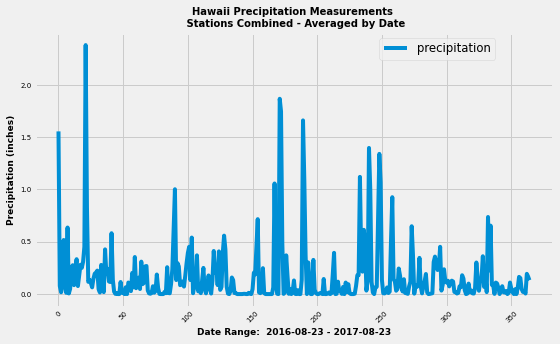

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
rec_dt = str(most_rect_dt)[2:-3]
# Calculate the date one year from the last date in data set.
one_yr_ago = str(eval(rec_dt[0:4])-1) +rec_dt[4:]

# Perform a query to retrieve the data and precipitation scores
precip_twelve = session.query(ref_Measurement.date,func.avg(ref_Measurement.prcp)).filter(ref_Measurement.date > one_yr_ago).group_by(ref_Measurement.date).order_by(ref_Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_twelve, columns=['date','prcp'])
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y/%m/%d')
precip_df.set_index(precip_df['date'])

# Sort the dataframe by date
precip_df.sort_index()
precip_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(use_index=True, y='prcp', figsize=(8,5))
plt.gcf().subplots_adjust(bottom=0.15)
plt.title("Precipitation Measurements \n Stations Combined - Averaged by Date", fontweight='bold',size=10)
plt.xlabel(f"Date Range:  {one_yr_ago} - {rec_date}", fontweight='bold', size=9)
plt.ylabel("Precipitation in inches", fontweight='bold', size=9)
plt.yticks(size=7)
plt.xticks(rotation=45, size=7)
plt.legend(["precipitation"],loc=1, fontsize='small', bbox_to_anchor=(.90, 1))
plt.tight_layout()
plt.savefig('precipitation_amounts.png')
plt.show()



In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
station_list = session.query(ref_Station.id,ref_Station.station,ref_Station.name)
print(f"There are {station_list.count()} stations in the dataset")

There are 9 stations in the dataset


In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(ref_Measurement.station,func.count(ref_Measurement.station)).group_by(ref_Measurement.station).order_by(func.count(ref_Measurement.station).desc())
for row in station_activity:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
highest_station_activity = session.query(ref_Measurement.station,
                  func.count(ref_Measurement.station)).group_by(ref_Measurement.station).order_by(func.count(ref_Measurement.station).desc()).limit(1).scalar()
print(f"The station with the hightest number of observations is {highest_station_activity}. ")

q = session.query(ref_Station.id,
                  ref_Station.name,
                  func.min(ref_Measurement.tobs),
                  func.max(ref_Measurement.tobs),
                  func.avg(ref_Measurement.tobs))\
.filter(ref_Measurement.station == ref_Station.station)\
.filter(ref_Measurement.station == highest_station_activity)
avg_tmp_rec = "{0:.1f}".format(q[0][4])
print(f"Most Active Station ID: {q[0][0]}, \
    Name: {highest_station_activity},\
    Location: {q[0][1]} \nResults: \n    Minimum temperature recorded:  {q[0][2]}\n\
    Maximum temperture recorded :  {q[0][3]}\n    Average temperature recorded:  {avg_tmp_rec}")

The station with the hightest number of observations is USC00519281. 
Most Active Station ID: 7,     Name: USC00519281,    Location: WAIHEE 837.5, HI US 
Results: 
    Minimum temperature recorded:  54.0
    Maximum temperture recorded :  85.0
    Average temperature recorded:  71.7


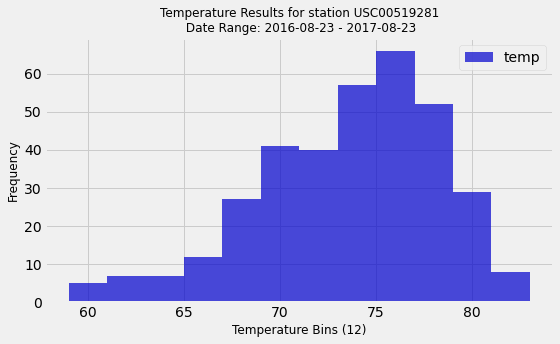

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_twelve = session.query(ref_Measurement.tobs)\
    .filter(ref_Measurement.date > one_yr_ago)\
    .filter(ref_Measurement.station == highest_station_activity)\
    .order_by(ref_Measurement.tobs).all()
tobs_df = pd.DataFrame(tobs_twelve, columns=['temp'])
tobs_df.head()
plt.subplots(figsize=(8,5))

plt.hist(tobs_df['temp'], bins=12, color="mediumblue", alpha=.7)
plt.title(f"Temperature Results for station {highest_station_activity}\n Date Range: \
{one_yr_ago} - {rec_date}",fontsize=12)
plt.xlabel('Temperature Bins (12)', fontsize=12)
plt.ylabel("Frequency", fontsize=12)
labels = ['temp']
plt.legend(labels)
plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig('temperature_results_hist.png')
plt.show()

# Close session

In [39]:
# Close Session
session.close()